## II.7. ARIMA-like models: Understanding autocorrelations


So far we've explored:

- Simple averaging
- Decomposition
- Exponential smoothings

These primarily **describe the trend** and **seasonality** in the data. E.g., __exponential smoothing__ looks at how the curve looks rather than *why* it behaves in a certain way.

We now turn to **ARIMA (AutoRegressive Integrated Moving Average)** models. 

**ARIMA** models take a different philosophical approach: they aim to describe the **autocorrelations** in the data. This means they try to capture the relationship between an observation and its own past values ("lags") or past forecast errors.

### II.7.A. The concept of stationarity

A crucial concept for ARIMA models is **stationarity**. 
    
A time series is said to be **stationary** if its statistical properties do not change over time. 

#### Formal definition


1.  **Strict Stationarity**: A process $\{y_t\}$ is strictly stationary if the joint probability distribution of $(y_{t_1}, y_{t_2}, \dots, y_{t_k})$ is identical to the joint probability distribution of $(y_{t_1+h}, y_{t_2+h}, \dots, y_{t_k+h})$ for all $k$, all time points $t_1, \dots, t_k$, and all time shifts $h$. This implies that the distribution of $y_t$ is the same for all $t$.

2.  **Weak or Second-Order Stationarity**: This is a less restrictive form and is commonly used. A process is wide-sense stationary if it satisfies:
    * The **mean** is constant: $\mathbb{E}(y_t) = \mu$, for all $t$.
    * The **variance** is constant and finite: $\mathrm{Var}(y_t) = \mathbb{E}((y_t - \mu)^2) = \sigma^2 < \infty$, for all $t$.
    * The **autocovariance** between $y_t$ and $y_{t-k}$ depends only on the lag $k$, and not on time $t$: $\mathrm{Cov}(y_t, y_{t-k}) = \gamma_k$, for all $t$.

#### Why is stationarity important?

- **If stationary**: We can estimate mean, variance, and autocorrelations from a single realization of the process. These sample moments become reliable estimators of the true underlying process moments. 

- **If not stationary** (e.g., it has a trend or changing variance): these properties are not constant, making it difficult to model reliably. Non-stationary series can lead to spurious correlations.

Visually, a stationary series will fluctuate around a constant mean and have roughly constant variance.

#### Autocovariance and Autocorrelation

These functions describe the linear dependence between values of the series at different points in time.

-   **Autocovariance Function ($\gamma_{t,s}$)**: This measures the covariance between $y_t$ and $y_s$:
    $$
    \gamma_{t,s} = \mathrm{Cov}(y_t, y_s) = \mathbb{E}[(y_t - \mu_t)(y_s - \mu_s)]
    $$
    Key properties include:
    * $\gamma_{t,t} = \mathrm{Var}(y_t)$ (the variance at time $t$).
    * $\gamma_{t,s} = \gamma_{s,t}$ (symmetry).

-   **Autocorrelation Function (ACF) ($\rho_{t,s}$)**: This is the normalized version of the autocovariance, providing a scale-free measure of linear dependence, ranging from -1 to 1:
    $$
    \rho_{t,s} = Corr(y_t, y_s) = \frac{ \mathrm{Cov}(y_t, y_s)}{\sqrt{ \mathrm{Var}(y_t)\mathrm{Var}(y_s)}} = \frac{\gamma_{t,s}}{\sqrt{\gamma_{t,t}\gamma_{s,s}}}
    $$
    Key properties include:
    * $\rho_{t,t} = 1$ (correlation of a value with itself is 1).
    * $\rho_{t,s} = \rho_{s,t}$ (symmetry).
    * $|\rho_{t,s}| \le 1$.
    If $\rho_{t,s} = 0$, then $y_t$ and $y_s$ are uncorrelated.

The ACF is a critical tool for understanding the temporal structure of a time series, helping us identify patterns and dependencies.

### II.7.B. The Random Walk Model

The **Random Walk (RW)** model:

$$
y_t = y_{t-1} + \epsilon_t
$$

where $\epsilon_t$ is **white noise** (a sequence of independent and identically distributed random variables with mean 0 and constant variance $\sigma^2_\epsilon$).

It is easy to show that:

$$y_t = y_0 + \sum_{i=1}^{t} \epsilon_i$$

the current value is the initial value plus the sum of all past shocks.

**Properties of a Random Walk:**
* **Non-stationary**: While the mean can be constant (if $\mathbb{E}(\epsilon_t)=0$ and $y_0$ is constant), the variance increases with time: $\mathrm{Var}(y_t) = t\sigma^2_\epsilon$.
* **Forecasts**: The optimal forecast for all future horizons is the last observed value, $\hat{y}_{t+h|t} = y_t$. This is why it's often called the "naive forecast".
* **Autocorrelations**: The ACF of a random walk will show very strong correlations that decay very slowly (or not at all), which is a hallmark of non-stationarity.

In [1]:
import numpy as np
import pandas as pd
from utils import ExampleDataLoader, plot_series_and_acf, plot_series_and_pacf

In [2]:
np.random.seed(123_456)

y_0 = 120
n_days = 147
index = pd.date_range(start="2025-01-01", periods=n_days, freq="D")
epsilon = np.random.normal(size=len(index))

y_rw = pd.Series(y_0 + np.cumsum(epsilon), index=index)

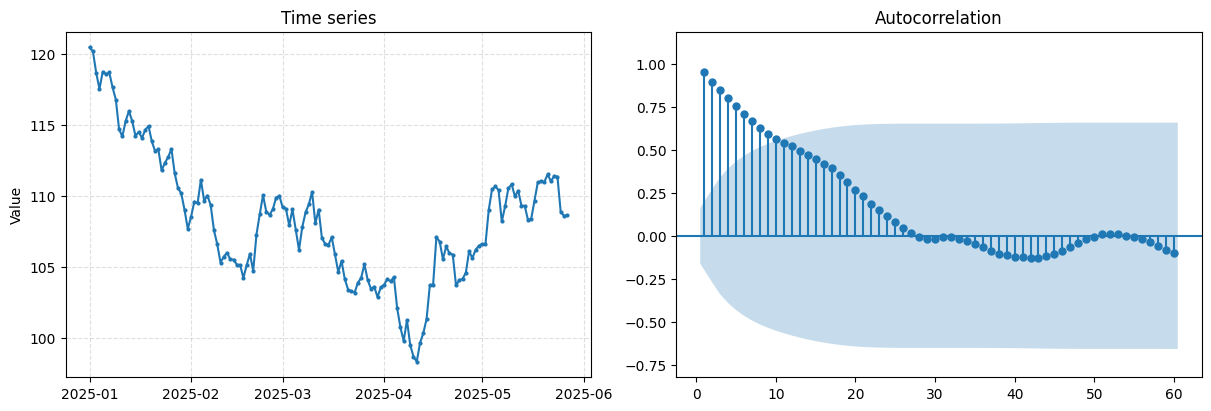

In [3]:
plot_series_and_acf(y_rw, lags=60)

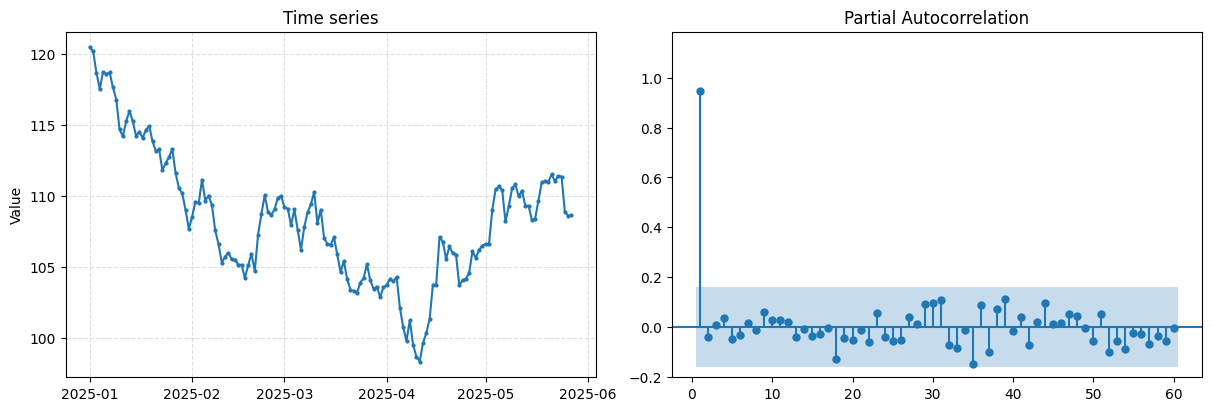

In [4]:
plot_series_and_pacf(y_rw, lags=60)

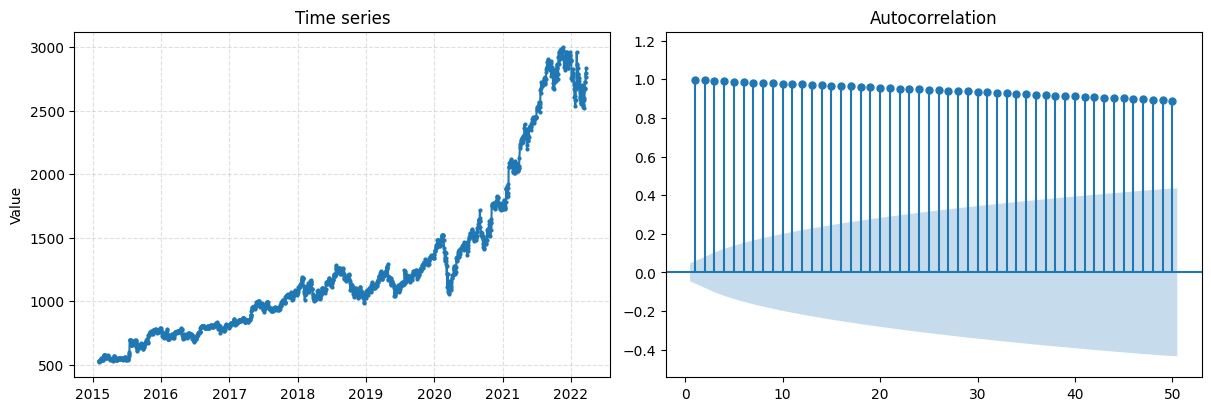

In [5]:
GOOGL = ExampleDataLoader("google").load().set_index("Date")
y_google = GOOGL["Close"][-5*360:]

plot_series_and_acf(y_google, lags=50)

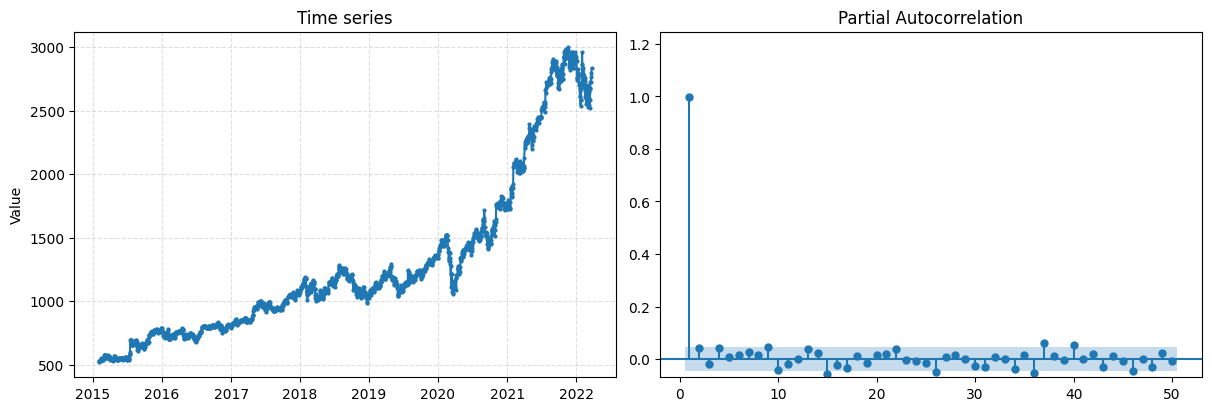

In [6]:
plot_series_and_pacf(y_google, lags=50)

### II.7.C. Differencing for stationarity: Thinking with autocorrelations

Many non-stationary time series can be made stationary by differencing. This involves computing the difference between consecutive observations.

The **first difference** is defined as:

$$
y'_t = y_t - y{t-1}
$$

Using the backward shift operator $B$, where $B\,y_t = y_{t-1}$, we can write this as:

$$
y'_t = (1-B)y_t
$$

If we apply first differencing to a random walk model $y_t = y_{t-1} + \epsilon_t$:

$$
\boxed{\qquad y'_t = y_t - y_{t-1} = (y_{t-1} + \epsilon_t) - y_{t-1} = \epsilon_t \qquad}
$$


The result is white noise $\epsilon_t$, which is stationary.

**Differencing** is crucial because it allows us to convert a non-stationary series into a stationary one, which can then be modeled with ARMA processes (which we'll discuss next). 

The "I" in ARIMA stands for "Integrated," which refers to this differencing step (integration being the reverse of differencing ).

#### The Backward Shift Operator (B)

The backward shift operator is very useful for describing **differencing**:

- A first difference $y'_t = y_t - y_{t-1}$ can be written as $(1-B)y_t$.
- A second difference $y''_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2}$ can be written as $(1-B)^2 y_t$.
- A seasonal difference of period $m$, $y_t - y_{t-m}$, can be written as $(1-B^m)y_t$.


In [7]:
from sktime.transformations.series.difference import Differencer

#### Random walk

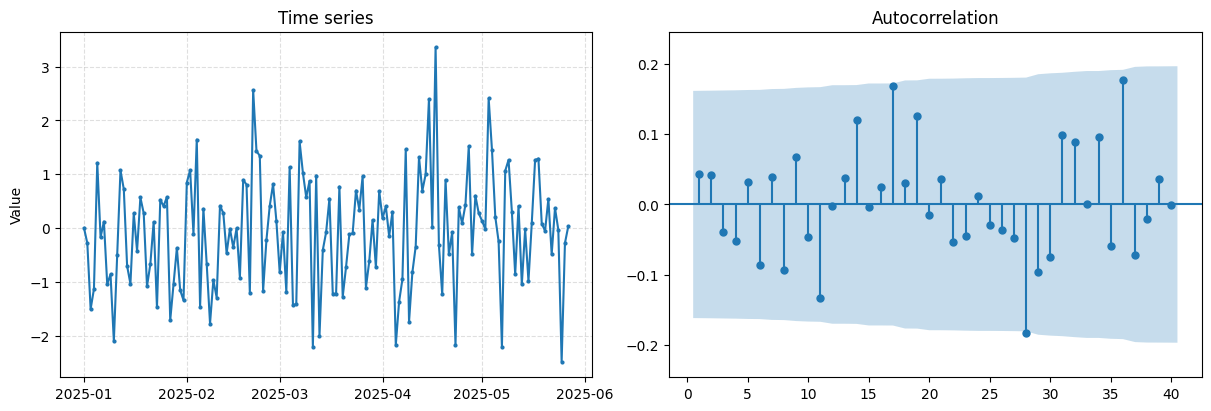

In [8]:
differencer = Differencer(lags=1)
y_rw_diff1 = differencer.fit_transform(y_rw)
plot_series_and_acf(y_rw_diff1)

#### Google stocks data

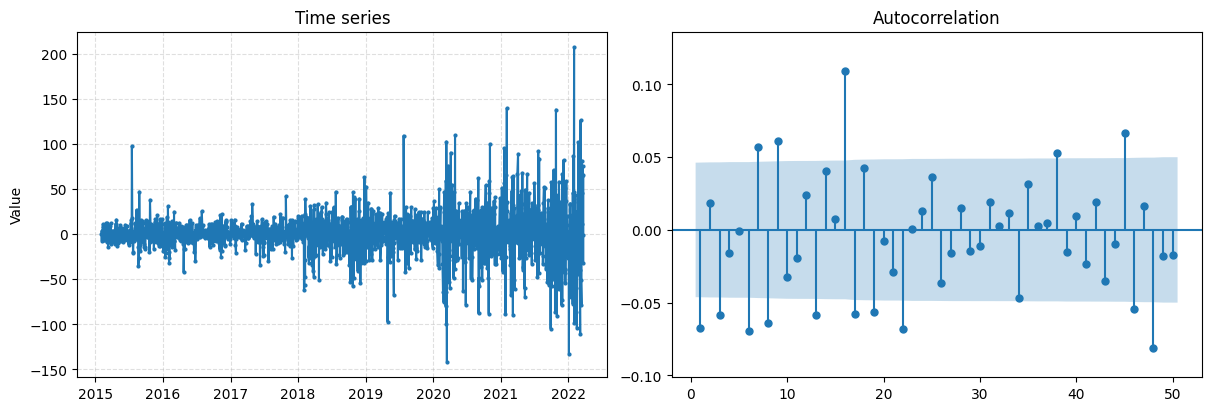

In [9]:
differencer = Differencer(lags=1)
y_google_diff1 = differencer.fit_transform(y_google)
plot_series_and_acf(y_google_diff1, lags=50)

**Notes:**
- Before differencing, the ACF showed slow decay, indicative of non-stationarity. 
- After first differencing, the trend is removed. 

#### Airplane data (trend and seasonality)

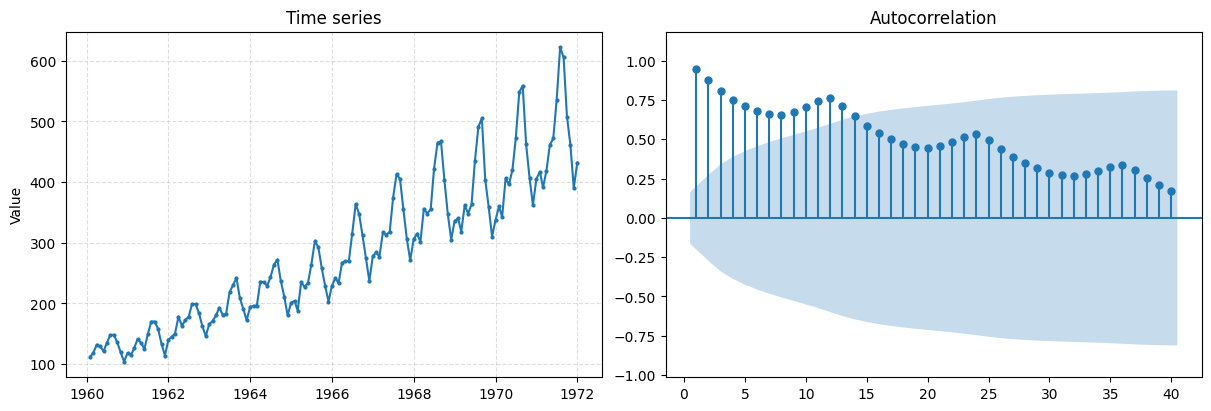

In [10]:
from sktime.datasets import load_airline

y_air = load_airline().reset_index(drop=True)
y_air.index = pd.date_range(start="1960-01-01", periods=len(y_air), freq="ME")

plot_series_and_acf(y_air)

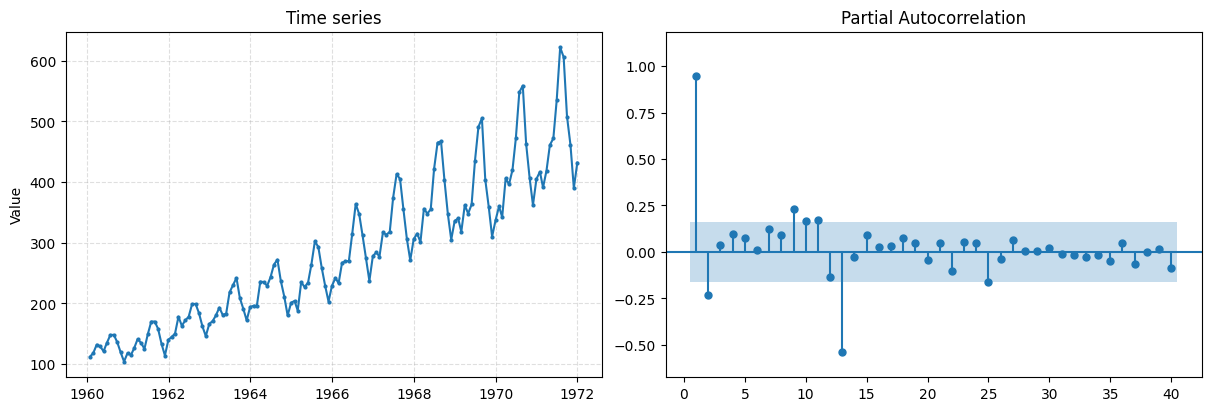

In [11]:
plot_series_and_pacf(y_air)

##### Monthly correlation

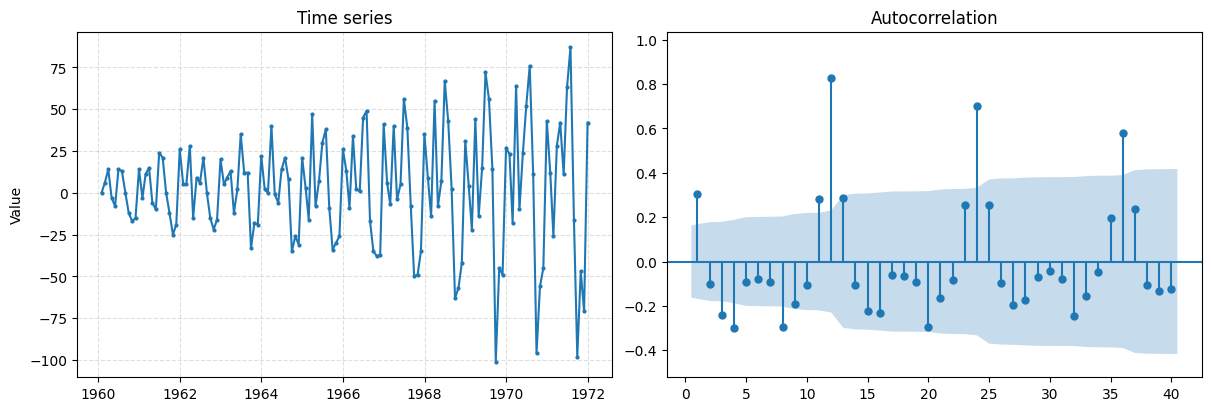

In [12]:
differencer = Differencer(lags=1) # Corresponds to (1-B)
y_air_diff1 = differencer.fit_transform(y_air)
plot_series_and_acf(y_air_diff1)

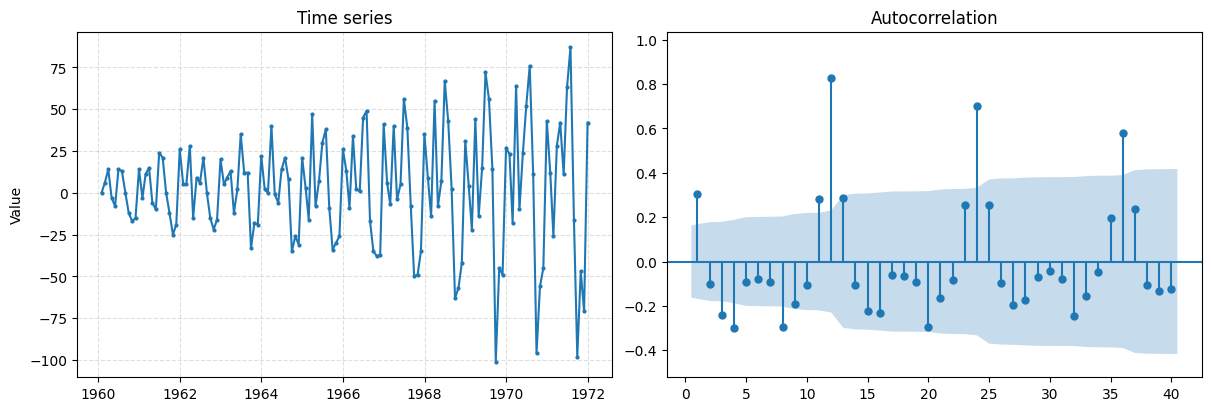

In [13]:
differencer = Differencer(lags=1) # Corresponds to (1-B)
y_air_diff1 = differencer.fit_transform(y_air)
plot_series_and_acf(y_air_diff1)

##### Yearly correlation

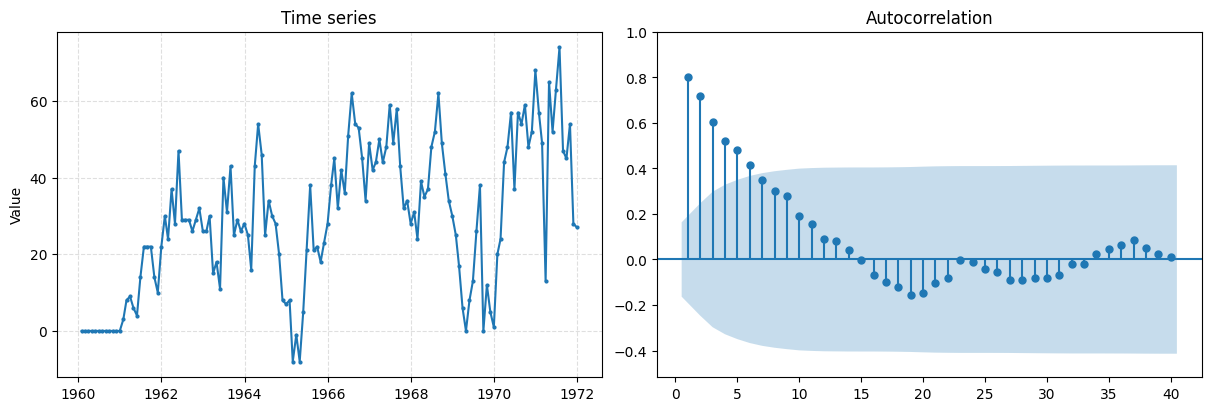

In [14]:
seasonal_differencer = Differencer(lags=12) # Corresponds to (1-B^12)
y_air_s_diff = seasonal_differencer.fit_transform(y_air)
plot_series_and_acf(y_air_s_diff)

##### Removing both montly and yearly correlations

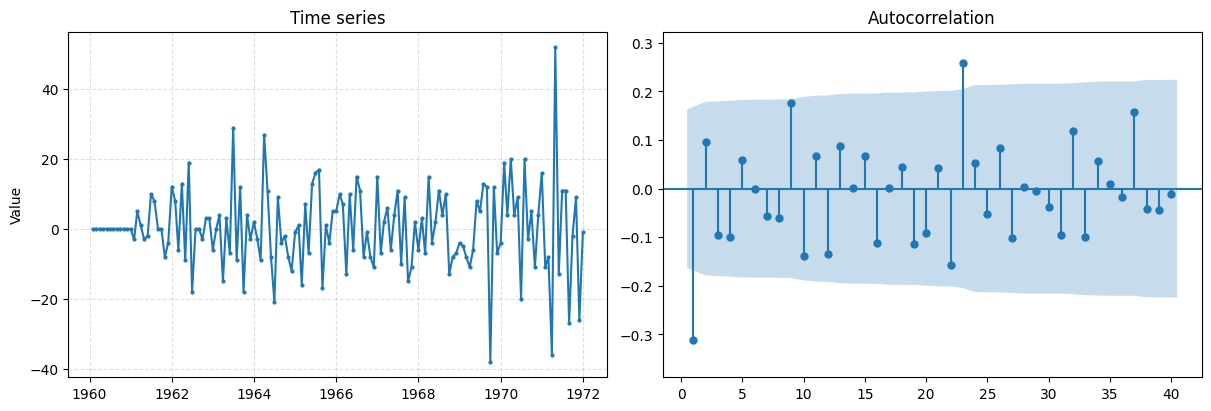

In [15]:
y_air_both_diff = seasonal_differencer.fit_transform(y_air_diff1)
plot_series_and_acf(y_air_both_diff)

### II.7.D. Beyond the Random Walk: AR, MA, and ARMA Models

- Differencing can help make a series stationary, a stationary series
- Some series may still have a structure that can be modeled.
- This structure often arises from correlations between observations at different lags or from correlations between past error terms.
- Autoregressive (AR), Moving Average (MA), and their combination, ARMA models, are designed to capture these types of linear dependencies in **stationary** time series.

#### Autoregressive models: AR(p)

The equation for an AR(p) is:
$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
$$
Or using the backward shift operator:
$$
(1 - \phi_1 B - \phi_2 B^2 - \dots - \phi_p B^p)y_t = c + \epsilon_t
$$
Where:
-   $c$ is a constant (related to the mean of the series).
-   $\phi_1, \phi_2, \dots, \phi_p$ are the autoregressive parameters of the model.
-   $\epsilon_t$ is a white noise error term.


##### Identifying AR(p) models

In [16]:
from utils import ArmaProcess, plot_acf_and_pacf

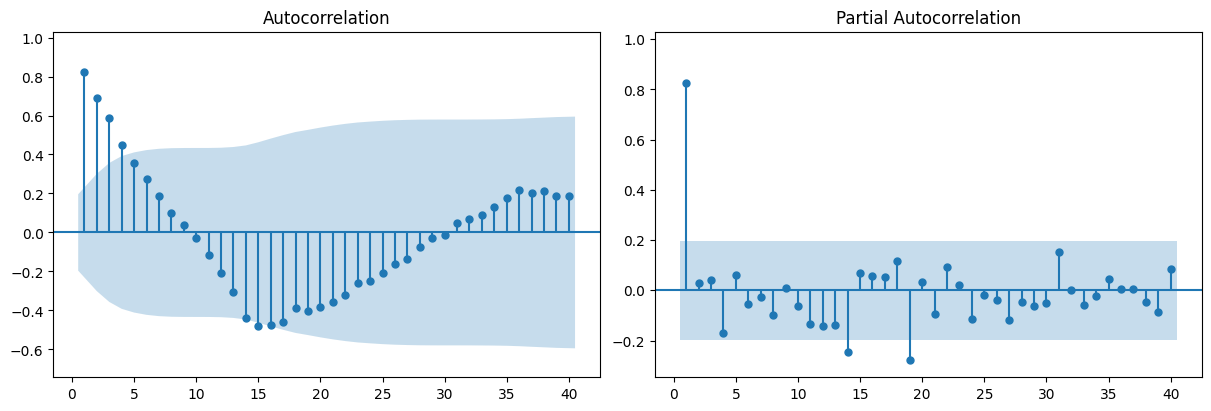

In [17]:
np.random.seed(123)
 
ar1_coeffs = np.array([1, -0.8]) 
ar1_process = ArmaProcess(ar=ar1_coeffs)
y_ar1 = pd.Series(ar1_process.generate_sample(nsample=100))

plot_acf_and_pacf(y_ar1)

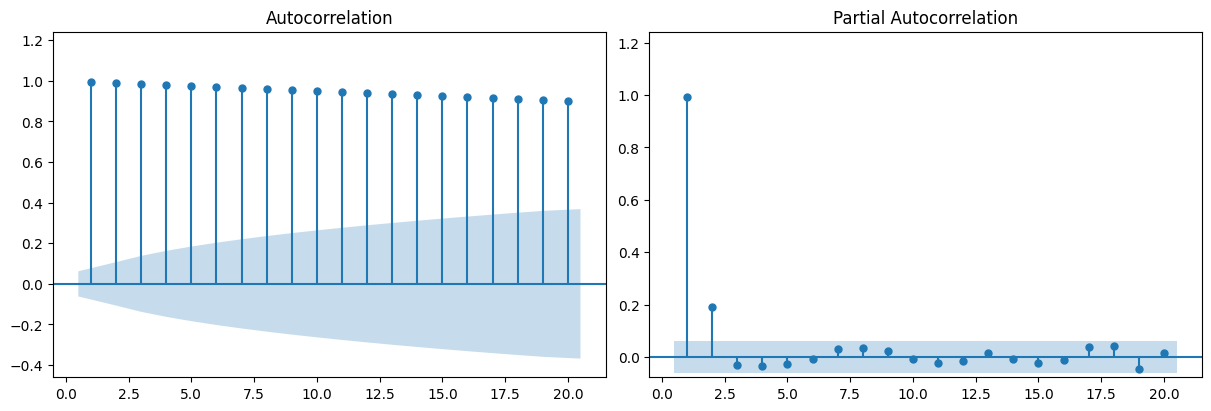

In [18]:
ar2_coeffs = np.array([1, -0.7, -0.3])
ar2_process = ArmaProcess(ar=ar2_coeffs)
y_ar2 = pd.Series(ar2_process.generate_sample(nsample=1_000))

plot_acf_and_pacf(y_ar2, lags=20)

AR(p) models have characteristic signatures in their Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF): 
-   **ACF**: Shows an exponential decay or a damped sine-wave pattern.
-   **PACF**: Cuts off sharply after lag $p$. This means the partial autocorrelation is significant for the first $p$ lags and then drops to effectively zero (Although this might not happen because of insufficient sample size)

#### Moving Average models: MA(q)

The equation for an MA(q) model is:
$$
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$
Or using the backward shift operator:
$$
y_t = c + (1 + \theta_1 B + \theta_2 B^2 + \dots + \theta_q B^q)\epsilon_t
$$

Where:

- $c$ is a constant (related to the mean of the series, often assumed to be 0 if the series $y_t$ has been mean-centered).
- $\theta_1, \theta_2, \dots, \theta_q$ are the moving average parameters.
- $\epsilon_t$ is a white noise error term.

##### Identifying MA(q) models

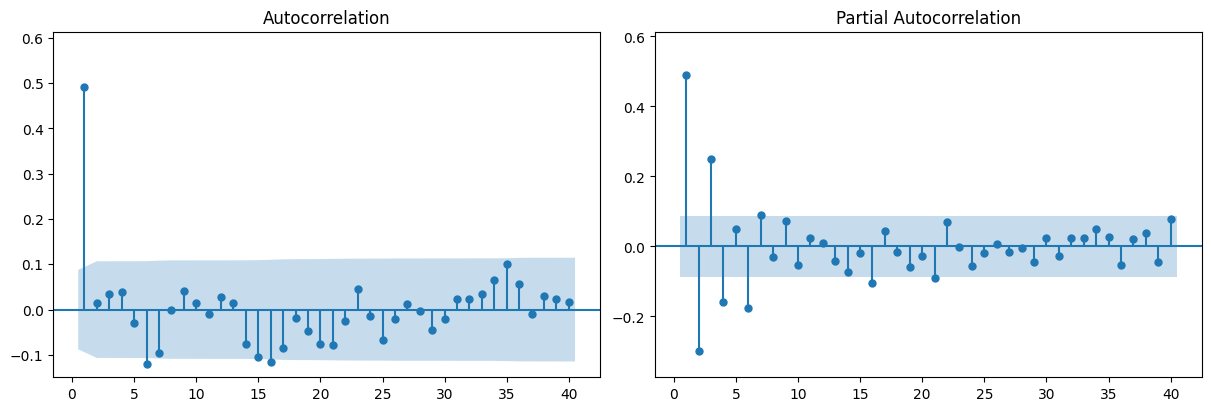

In [19]:
np.random.seed(123)

ma_coeffs = np.array([1, 1.3]) 
ma_process = ArmaProcess(ma=ma_coeffs)
y_ma1 = pd.Series(ma_process.generate_sample(nsample=500))

plot_acf_and_pacf(y_ma1)

MA(q) models have characteristic signatures in their Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF):

- **ACF**: Cuts off sharply after lag $q$. This means the autocorrelation is significant only for the first $q$ lags and effectively zero afterward (though small sample sizes may obscure this cutoff).

- **PACF**: Shows an exponential decay or a damped sine-wave pattern.

#### ARMA(p,q) models

An ARMA(p,q) model combines both autoregressive and moving average components:

$$
y_t = c + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}
$$

Or using the B operator:

$$
(1 - \phi_1 B - \dots - \phi_p B^p)y_t = c + (1 + \theta_1 B + \dots + \theta_q B^q)\epsilon_t
$$

##### Identifying ARMA(p,q) models

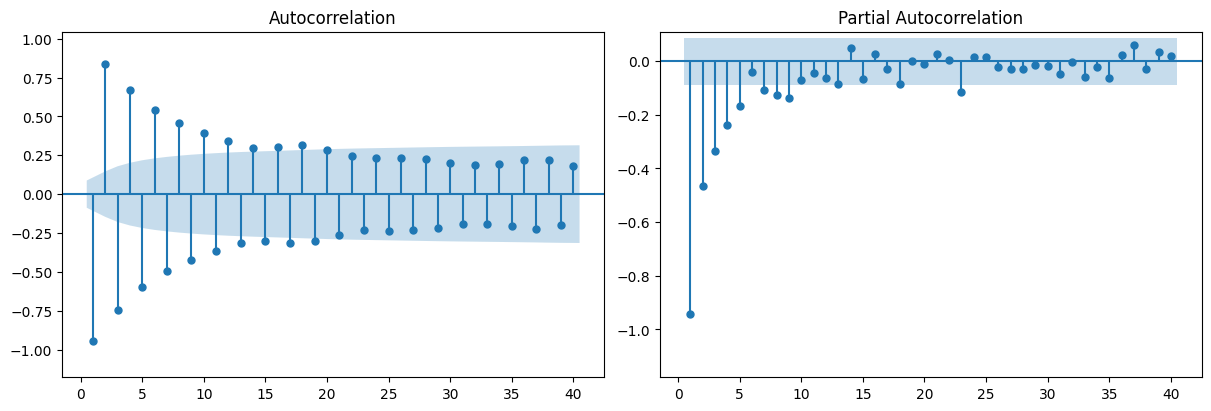

In [20]:
np.random.seed(123)

arma_process = ArmaProcess(ar=np.array([1, 0.9]), ma=np.array([1, -0.9]))
y_arma = pd.Series(arma_process.generate_sample(nsample=500))

plot_acf_and_pacf(y_arma)

Both the **ACF** and **PACF** will typically show decaying patterns (exponential decay or damped sine waves) after the first few lags. Their shapes can be complex, making identification from plots alone more challenging than for pure AR or MA processes.

## II.7.E. ARIMA models

An ARIMA(p,d,q) model is characterized by:

-   **p**: For AR(p), number of lag observations of the series included in the model.
-   **d**: For I(d), differencing, number of times the raw observations are differenced to achieve stationarity.
-   **q**: For MA(q), number of lagged forecast errors included in the model.

The general equation using the backward shift operator $B$ is:

$$
(1-\phi_{1}B-\dots-\phi_{p}B^{p})(1-B)^{d}y_{t} = c + (1+\theta_{1}B+\dots+\theta_{q}B^{q})\epsilon_{t}
$$

Where:
-   $y_t$ is the original time series.
-   $\phi_i$ are the AR parameters.
-   $\theta_j$ are the MA parameters.
-   $\epsilon_t$ is white noise.
-   $c$ is a constant (if $d > 0$, $c$ often represents the mean of the $d$-th differenced series, implying a drift in the original series).

The process of selecting appropriate $p, d, q$ values typically follows the **Box-Jenkins methodology**, involving analysis of the time series plot, ACF, and PACF of the original and differenced series.

In [21]:
from utils import plot_series

from matplotlib import pyplot as plt
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

In [22]:
y = load_airline()

fh = ForecastingHorizon(pd.period_range(start=y.index[-1] + 1, periods=12, freq=y.index.freq), is_relative=False)
forecaster_arima = ARIMA(order=(2, 1, 2), suppress_warnings=True)
 
forecaster_arima.fit(y)
y_arima_intervals = forecaster_arima.predict_interval(coverage=0.9, fh=fh)
y_arima = forecaster_arima.predict(fh)

/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: F

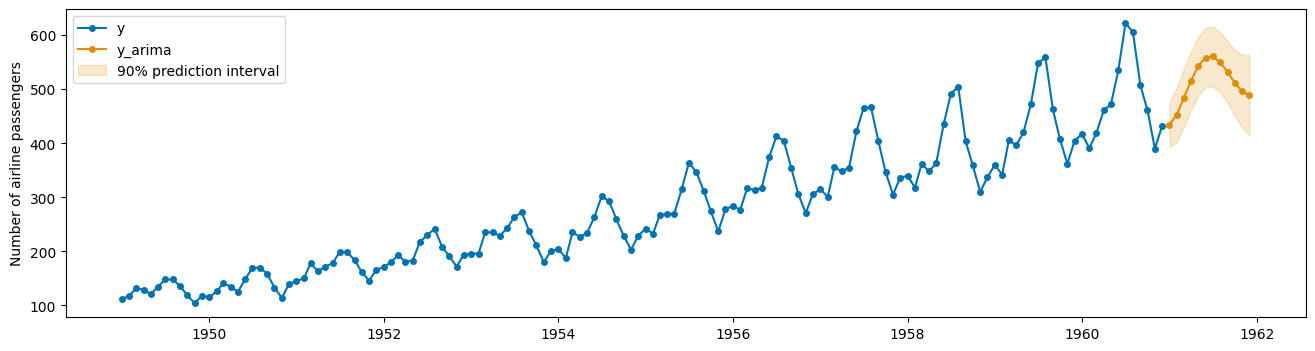

In [23]:
fig, ax = plot_series(y, y_arima, labels=["y", "y_arima"], pred_interval=y_arima_intervals)
ax.legend()
plt.show()

#### ARIMA Identification: Box-Jenkins method

![](../img/box-jenkins.png)

**Source**: _Makriadakis et al. (1998)_

#### Automated ARIMA Identification

The Box-Jenkins methodology **requires careful** examination of ACF/PACF plots and can be time-consuming and somewhat subjective in identifying the optimal $p, d, q$ orders for an ARIMA model.

##### Hyndman-Khandakar AutoARIMA algorithm (2008)

Many lgorithms have been developed to automatically select an appropriate ARIMA model. One of the most widely known is the one by Hyndman and Khandakar (HK).

The HK methodn is implemented as `AutoARIMA` in `pmdarima` (and wrapped by `sktime`).

The general approach of such algorithms usually involves:

1.  **Determining the order of differencing ($d$)**: This is often done using a sequence of unit root tests, like the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test or Augmented Dickey-Fuller (ADF) test, to achieve stationarity. Seasonal differencing ($D$) is also determined if seasonality is present.

2.  **Stepwise Search for $p$ and $q$ (and seasonal $P, Q$)**: Once the differencing orders are established, the algorithm iteratively searches through a space of possible AR ($p$) and MA ($q$) orders (and their seasonal counterparts $P, Q$ if applicable). It fits multiple candidate models and selects the one that minimizes an information criterion, typically the _Akaike Information Criterion_ (AIC), _Corrected AIC_ (AICc), or _Bayesian Information Criterion_ (BIC). These criteria balance model fit with model complexity.

`AutoARIMA` key benefits include:
-   Automatic determination of differencing orders ($d, D$).
-   Automatic selection of $p, q, P, Q$ by minimizing an information criterion.
-   Handles seasonality by fitting SARIMA models.

In [24]:
from sktime.forecasting.arima import AutoARIMA

##### Airline data

In [25]:
y = load_airline()
forecaster_autoarima = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True) 
forecaster_autoarima.fit(y)  

/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: F

AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True)

In [26]:
forecaster_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -666.022
Date:                Mon, 26 May 2025   AIC                           1344.044
Time:                        11:41:23   BIC                           1361.822
Sample:                    01-31-1949   HQIC                          1351.268
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6619      0.193      3.426      0.001       0.283       1.041
ar.L1          1.6479      0.028     58.897      0.000       1.593       1.703
ar.L2         -0.9095      0.025    -36.761      0.000      -0.958      -0.861
ma.L1         -1.9079      0.350     -5.453      0.000      -2.594      -1.222
ma.L2          0.9977      0.365      2.730      0.006       0.281       1.714
sigma2       611.6506    243.652      2.510      0.012     134.102    1089.199
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.27   Prob(JB):                         0.25
Heteroskedasticity (H):               7.02   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
fh = ForecastingHorizon(range(1,12), is_relative=True)
y_arima = forecaster_autoarima.predict(fh=fh)
y_arima_intervals = forecaster_autoarima.predict_interval(coverage=0.9, fh=fh)

/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


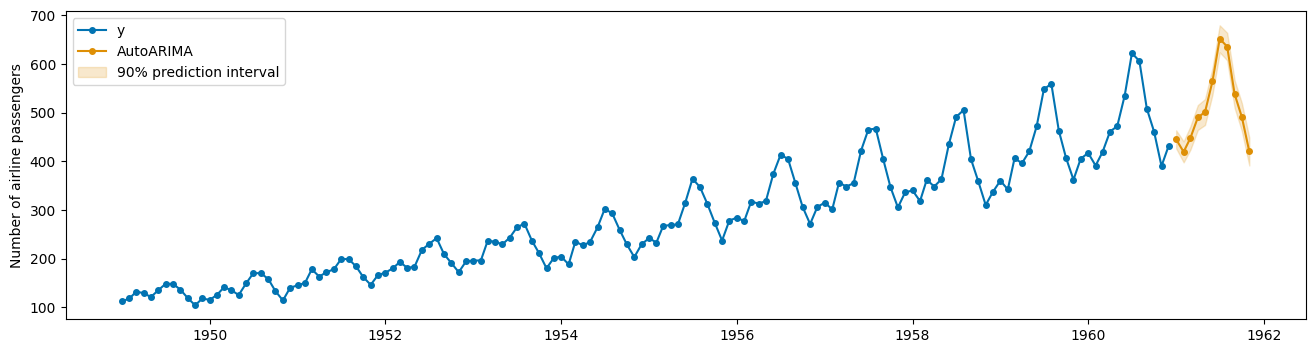

In [28]:
fig, ax = plot_series(y, y_arima, labels=["y", "AutoARIMA"], pred_interval=y_arima_intervals)
ax.legend()
plt.show()

##### Energy data

In [29]:
y = ExampleDataLoader("energy").load().set_index("datetime")[-100:]

forecaster_autoarima = AutoARIMA(sp=24, d=0, max_p=2, max_q=2, suppress_warnings=True) 
forecaster_autoarima.fit(y)

/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: F

AutoARIMA(d=0, max_p=2, max_q=2, sp=24, suppress_warnings=True)

In [30]:
fh = ForecastingHorizon(range(1,24), is_relative=True)
y_arima = forecaster_autoarima.predict(fh=fh)
y_arima_intervals = forecaster_autoarima.predict_interval(coverage=0.9, fh=fh)

/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/migduroli/dev/loyola/ml4ts/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


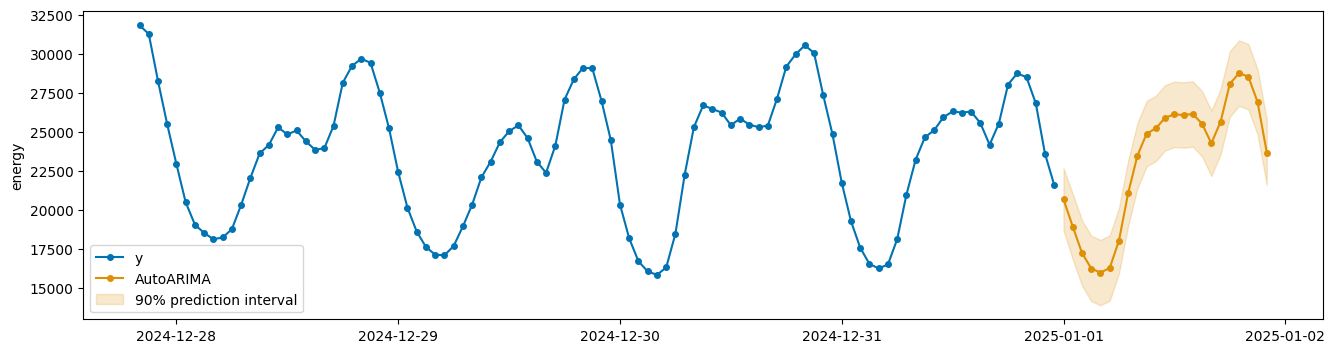

In [31]:
fig, ax = plot_series(y, y_arima, labels=["y", "AutoARIMA"], pred_interval=y_arima_intervals)
ax.legend()
plt.show()

In [32]:
forecaster_autoarima.get_fitted_params()

{'intercept': -148.90519886990322,
 'ma.L1': 0.31964254032655504,
 'ar.S.L24': 0.06713956680357472,
 'ar.S.L48': 0.06688715111390717,
 'ma.S.L24': -0.13180425870632467,
 'sigma2': 1468231.3588133834,
 'order': (0, 0, 1),
 'seasonal_order': (2, 1, 1, 24),
 'aic': 1320.8236355595886,
 'aicc': 1322.0410268639364,
 'bic': 1334.8080356013065,
 'hqic': 1326.4124782435115}